In [555]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from config import *

## **Test/Positve dataset**

1. **Dataset before 2020-05-12**

In [458]:
url_test1="https://www.data.gouv.fr/fr/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20"
dtype={'dep': str,'clage_covid':str,'nb_test':int,'nb_pos':int}
df_test1=pd.read_csv(url_test1,sep = ';',dtype=dtype)
df_test1=df_test1.drop(["nb_test_h","nb_test_f","nb_pos_h","nb_pos_f"],axis=1)

In [459]:
df_test1=df_test1.drop(df_test1[(df_test1["jour"]<"2020-03-18") | (df_test1["jour"]>"2020-05-12")].index)
df_test1.head()

,dep,jour,clage_covid,nb_test,nb_pos
48,01,2020-03-18,0,37,8
49,01,2020-03-18,A,0,0
50,01,2020-03-18,B,15,1
51,01,2020-03-18,C,11,3
52,01,2020-03-18,D,4,3


In [460]:
df_test1=df_test1.drop(df_test1[df_test1["clage_covid"] != "0"].index)
df_test1=df_test1.drop("clage_covid",axis=1)
df_test1.head()

,dep,jour,nb_test,nb_pos
48,01,2020-03-18,37,8
54,01,2020-03-19,82,13
60,01,2020-03-20,44,9
66,01,2020-03-21,13,1
72,01,2020-03-22,4,0


2. **Dataset after 2020-05-12**

In [461]:
url_test2="https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
dtype={'dep': str,'P':int,'T':int,'cl_age':int}
df_test2=pd.read_csv(url_test2,sep = ';',dtype=dtype)
df_test2.head()

,dep,jour,P,T,cl_age90
0,01,2020-05-13,0,16,9
1,01,2020-05-13,1,16,19
2,01,2020-05-13,0,33,29
3,01,2020-05-13,1,71,39
4,01,2020-05-13,0,53,49


In [462]:
df_test2.loc[df_test2['dep'] == '75']

,dep,jour,P,T,cl_age90
142725,75,2020-05-13,0,62,9
142726,75,2020-05-13,0,40,19
142727,75,2020-05-13,6,188,29
142728,75,2020-05-13,2,234,39
142729,75,2020-05-13,2,207,49
...,...,...,...,...,...
144623,75,2020-11-01,18,147,69
144624,75,2020-11-01,21,103,79
144625,75,2020-11-01,12,63,89
144626,75,2020-11-01,4,37,90


In [463]:
df_test2=df_test2.rename(columns={'P':'nb_pos','T':'nb_test'})
df_test2=df_test2.drop("cl_age90",axis=1)

In [464]:
df_test2=df_test2.groupby(["dep","jour"]).tail(1)
df_test2.head()

,dep,jour,nb_pos,nb_test
10,01,2020-05-13,9,328
21,01,2020-05-14,9,429
32,01,2020-05-15,5,440
43,01,2020-05-16,0,142
54,01,2020-05-17,0,30


3. **Merge in one dataset**

In [465]:
df_test = pd.concat([df_test1,df_test2],ignore_index=True)
df_test['nb_test_cum']=df_test.groupby("dep")['nb_test'].cumsum()
df_test['nb_pos_cum']=df_test.groupby("dep")['nb_pos'].cumsum()
df_test.head()

,dep,jour,nb_test,nb_pos,nb_test_cum,nb_pos_cum
0,01,2020-03-18,37,8,37,8
1,01,2020-03-19,82,13,119,21
2,01,2020-03-20,44,9,163,30
3,01,2020-03-21,13,1,176,31
4,01,2020-03-22,4,0,180,31


## **Hospital dataset**

In [466]:
url2="https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
df_hospital = pd.read_csv(url2,sep=';')
df_hospital.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [467]:
df_hospital = df_hospital.drop(df_hospital[(df_hospital["sexe"]==1) | (df_hospital["sexe"]==2 ) ].index).reset_index(drop=True)
df_hospital = df_hospital.drop(["sexe"],axis=1)
df_hospital.head()

,dep,jour,hosp,rea,rad,dc
0,01,2020-03-18,2,0,1,0
1,02,2020-03-18,41,10,18,11
2,03,2020-03-18,4,0,1,0
3,04,2020-03-18,3,1,2,0
4,05,2020-03-18,8,1,9,0


## **Create departement longitude/latitude Dataframe**

Source: <a href="https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf" target="_blank">https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf</a>

Source: <a href="https://www.coordonnees-gps.fr/" target="_blank">https://www.coordonnees-gps.fr/</a>

In [527]:
departements= df_test["dep"].unique()

In [526]:
data={'dep':departements,
      'dep_name':['Ain','Aisne','Allier','Alpes-de-Haute-Provence','Hautes-Alpes','Alpes_Maritimes','Ardeche','Ardennes','Ariege','Aube','Aude','Aveyron','Bouches-du-Rhône','Calvados','Cantal','Charente','Charente-Maritime','Cher','Correze',"Côte-d'Or","Côtes-D'Armor","Creuse","Dordogne","Doubs","Drome","Eure","Eure-et-Loire","Finistère","Corde-du-Sud","Haute-Corse","Gard","Haute-Garonne","Gers","Gironde","Hérault","Ille-et-Vilaine","Indre","Indre-et-Loire","Isère","Jura","Landes","Loir-et-Cher","Loire","Haute-Loire","Loire-Atlantique","Loiret","Lot","Lot-et-Garonne","Lozère","Manne-et-Loire","Manche","Marne","Haute-Marne","Mayenne","Meurthe-et-Moselle","Meuse","Morbihan","Moselle","Nièvre","Nord","Oise","Orne","Pas-de-Calais","Puy-de-Dôme","Pyrénées-Altantiques","Hautes-Pyrénées","Pyrénées-Orientales","Bas-Rhin","Haut-Rhin","Rhone","Haute-Saône","Saône-et-Loire","Sarthe","Savoie","Haute-Savoie","Paris","Seine-Maritime","Seine-et-Marne","Yvellines","Deux-Sèvres","Somme","Tarn","Tarn-et-Garonne","Var","Vaucluse","Vendée","Vienne","Haute-Vienne","Vosges","Yonne","Territoire de Belfort","Essonne","Hauts-de-Seine","Seine-Saint_Denis","Val-de-Marne","Val-d'Oise","Guadeloupe","Martinique","Guyane","La Réunion","Mayotte","Saint-Pierre-et-Miquelon","Saint-Barthélémy","Saint-Martin"],
      'lat':[46.1,49.55,44.1,44.09,44.66,43.94,44.73,49.61,42.94,48.31,43.10,44.28,43.54,49.10,45.01,45.71,45.76,47.07,45.34,47.43,48.44,46.08,45.13,47.16,44.68,49.10,48.39,48.27,41.88,42.37,43.99,43.35,43.68,44.84,43.90,48.18,46.80,47.24,45.27,46.73,43.96,47.61,45.72,45.13,47.38,47.85,44.63,44.37,44.51,47.39,49.08,48.38,48.09,48.12,48.79,49.00,47.85,49.02,47.10,50.45,49.39,48.61,50.49,45.73,43.28,43.05,42.61,48.65,47.86,45.86,47.63,46.64,48.00,45.47,46.04,48.85,49.65,48.60,48.97,46.53,49.97,43.77,44.07,43.47,43.99,46.67,46.55,45.87,48.19,47.84,47.62,48.52,48.83,48.90,48.77,49.07,16.00,14.60,4.93,-20.88,-12.77,46.78,17.90,18.06],
      'long':[5.33,3.56,2.35,6.23,6.21,7.12,4.41,4.61,1.53,4.14,2.35,2.72,5.03,-0.37,2.66,0.20,-0.71,2.52,1.81,4.78,-2.85,2.04,0.70,6.37,5.15,1.00,1.36,-4.04,8.97,9.23,4.17,1.23,0.45,-0.58,4.47,-1.64,1.62,0.69,5.61,5.69,-0.80,1.41,4.16,3.81,-1.71,2.26,1.59,0.46,3.49,-0.53,-1.34,7.47,5.15,-0.67,6.16,5.39,-2.83,6.65,3.51,3.20,2.42,0.11,2.27,3.14,-0.75,0.16,2.51,7.56,7.27,4.66,6.07,4.53,0.19,6.45,6.44,2.35,1.04,2.97,1.97,-0.32,2.29,2.18,1.28,6.18,5.14,-1.28,0.50,1.23,6.37,3.57,6.92,2.26,2.24,2.48,2.45,2.17,-61.73,-61.06,-52.32,55.45,45.22,-56.19,-62.81,-63.08]
     }
print(len(data['dep_name']))
df_coord = pd.DataFrame(data,columns=['dep','dep_name','lat','long'])
df_coord.tail()

104


,dep,dep_name,lat,long
99,974,La Réunion,-20.88,55.45
100,976,Mayotte,-12.77,45.22
101,975,Saint-Pierre-et-Miquelon,46.78,-56.19
102,977,Saint-Barthélémy,17.90,-62.81
103,978,Saint-Martin,18.06,-63.08


## **Complete Dataset**

In [533]:
df_dep = pd.merge(df_hospital,df_test,on=['dep','jour'])
df_dep = pd.merge(df_dep,df_coord,on=['dep'])
df_dep=df_dep.sort_values(['dep','jour'])

In [534]:
df_dep.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long
0,01,2020-03-18,2,0,1,0,37,8,37,8,Ain,46.1,5.33
1,01,2020-03-19,2,0,1,0,82,13,119,21,Ain,46.1,5.33
2,01,2020-03-20,2,0,1,0,44,9,163,30,Ain,46.1,5.33
3,01,2020-03-21,4,0,1,0,13,1,176,31,Ain,46.1,5.33
4,01,2020-03-22,8,1,2,0,4,0,180,31,Ain,46.1,5.33


In [535]:
df_dep['death rate']=df_dep['dc']/df_dep['nb_pos_cum']*100
df_dep.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,death rate
0,01,2020-03-18,2,0,1,0,37,8,37,8,Ain,46.1,5.33,0.0
1,01,2020-03-19,2,0,1,0,82,13,119,21,Ain,46.1,5.33,0.0
2,01,2020-03-20,2,0,1,0,44,9,163,30,Ain,46.1,5.33,0.0
3,01,2020-03-21,4,0,1,0,13,1,176,31,Ain,46.1,5.33,0.0
4,01,2020-03-22,8,1,2,0,4,0,180,31,Ain,46.1,5.33,0.0


In [536]:
df_last_update=df_dep.groupby("dep").tail(1).reset_index(drop=True)
df_last_update.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,death rate
0,01,2020-11-01,279,30,671,145,129,35,148205,18490,Ain,46.10,5.33,0.784208
1,02,2020-11-01,159,21,1310,320,54,11,88873,6691,Aisne,49.55,3.56,4.782544
2,03,2020-11-01,210,15,354,72,62,18,66500,4363,Allier,44.10,2.35,1.650241
3,04,2020-11-01,67,11,202,24,36,13,37023,2227,Alpes-de-Haute-Provence,44.09,6.23,1.077683
4,05,2020-11-01,176,24,224,39,59,34,25796,2855,Hautes-Alpes,44.66,6.21,1.366025


In [537]:
df_last_update.iloc[75]

dep                    75
jour           2020-11-01
hosp                 1185
rea                   254
rad                  8399
dc                   2099
nb_test              1196
nb_pos                243
nb_test_cum        815133
nb_pos_cum          85244
dep_name            Paris
lat                 48.85
long                 2.35
death rate        2.46234
Name: 75, dtype: object

## **Plot Graph**

In [551]:
color_scale = ["#fadc8f",
        "#f9d67a",
        "#f8d066",
        "#f8c952",
        "#f7c33d",
        "#f6bd29",
        "#f5b614",
        "#F4B000",
        "#eaa900",
        "#e0a200",
        "#dc9e00",]

In [556]:
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)

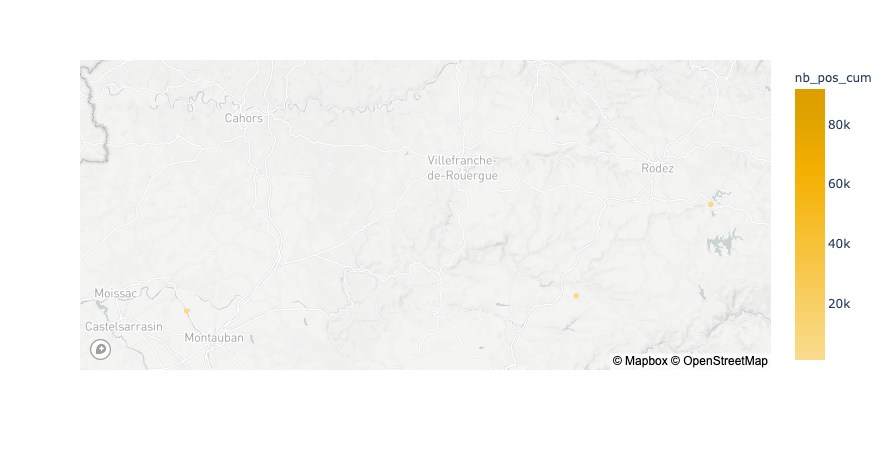

In [557]:
fig = px.scatter_mapbox(
    df_last_update,
    lat = "lat",
    lon = "long",
    color = "nb_pos_cum",
    size_max = 50,
    hover_name = "dep_name",
    hover_data = ["nb_pos_cum","dc","dep_name"],
    color_continuous_scale = color_scale,
)
fig.show()

In [492]:
df = pd.read_csv('datasets/covid_19_data.csv')

In [493]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [475]:
df['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [476]:
df = df.drop(df[(df["Country/Region"]=="('St. Martin',)")].index)

In [477]:
countries = df['Country/Region'].unique()
countries.sort()
print(countries)

[' Azerbaijan' 'Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burma' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Cayman Islands' 'Central African Republic' 'Chad'
 'Channel Islands' 'Chile' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' 'Croatia' 'Cuba' 'Curacao' 'Cyprus'
 'Czech Republic' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Faroe Islands' 'Fiji' 'Finland' 'France' 'French Guiana' 'Gabon'
 'Gambia' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece'
 'Greenland' 'Grenada' 'Guadeloupe' 'Gua

In [478]:
df_country=df.groupby(['Country/Region','ObservationDate'])[["Confirmed","Deaths","Recovered"]].sum().reset_index()
df_country.head(30)

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
0,Azerbaijan,02/28/2020,1.0,0.0,0.0
1,Afghanistan,02/24/2020,1.0,0.0,0.0
2,Afghanistan,02/25/2020,1.0,0.0,0.0
3,Afghanistan,02/26/2020,1.0,0.0,0.0
4,Afghanistan,02/27/2020,1.0,0.0,0.0
5,Afghanistan,02/28/2020,1.0,0.0,0.0
6,Afghanistan,02/29/2020,1.0,0.0,0.0
7,Afghanistan,03/01/2020,1.0,0.0,0.0
8,Afghanistan,03/02/2020,1.0,0.0,0.0
9,Afghanistan,03/03/2020,1.0,0.0,0.0


In [479]:
df_france=df_country[(df_country["Country/Region"]=="France")]
df_france.head(30)

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
12088,France,01/24/2020,2.0,0.0,0.0
12089,France,01/25/2020,3.0,0.0,0.0
12090,France,01/26/2020,3.0,0.0,0.0
12091,France,01/27/2020,3.0,0.0,0.0
12092,France,01/28/2020,4.0,0.0,0.0
12093,France,01/29/2020,5.0,0.0,0.0
12094,France,01/30/2020,5.0,0.0,0.0
12095,France,01/31/2020,5.0,0.0,0.0
12096,France,02/01/2020,6.0,0.0,0.0
12097,France,02/02/2020,6.0,0.0,0.0


In [480]:
df_france.iloc[-1][:]

Country/Region         France
ObservationDate    09/23/2020
Confirmed              508456
Deaths                  31447
Recovered               96498
Name: 12331, dtype: object

In [481]:
y_data = np.array([
    df_france['Confirmed_acc'],
    df_france['Deaths_acc'],
    df_france['Recovered']
])
labels = ['Confirmed', 'Deaths', 'Recovered']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)']
line_size = [2, 4, 2]

KeyError: 'Confirmed_acc'

In [ ]:
fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=df_france['ObservationDate'], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

fig.show()